# **Introduction**

The aim of this mini project is to illustrate applicability of Gen AI agents in labelling reviews based on a list predefined categories. We simply define each category and the agents will apply the relevant label. This approach can be used on several types of datasets in different scenarios.

The data for this project was taken from kaggle [128k Airline Reviews Dataset](https://www.kaggle.com/datasets/joelljungstrom/128k-airline-reviews).

In [57]:
# loading of necessary packages

import pandas as pd
pd.options.display.show_dimensions = False
import random
random.seed(42)
import json
import os
from google.colab import userdata
api_key = userdata.get('API_OpenAI')

# Set the environment variable
os.environ['OPENAI_API_KEY'] = api_key


In [58]:
%%capture
pip install --upgrade openai

In [59]:
import openai

# Get the API key from the environment variable
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key is None:
    raise ValueError("No OPENAI_API_KEY found in environment variables")

openai.api_key = openai_api_key

Here we import openai and check for the API key.

In [60]:
from openai import OpenAI
client = OpenAI()

model="gpt-4o-mini-2024-07-18"
temperature=0.2

In [61]:
def get_chat_gpt_response(prompt, model=model, temperature=temperature):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=200,
        n=1, # we only need one response to the parameter is set to 1
        stop=None,
        temperature=temperature
    )

    return response.choices[0].message.content.strip()  # Accesses the response from the message object


 We define the above function to handle the API call, retrieve the response, and return a clean text output.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Loading the Airline Review Data and the Pre-Defined Categories.**

In [63]:
airline_review_catigories = pd.read_excel('/content/drive/MyDrive/gpt_project_1/aline_review_cat_def.xlsx')
airline_reviews = pd.read_excel('/content/drive/MyDrive/gpt_project_1/airline_data.xlsx')


In [64]:
for index, row in airline_review_catigories.iterrows():
    category = row['Category']
    definition = row['Details']
    print(f"{category}: {definition}\n")

Pre-Flight Preparation: Experience with the online platform when Booking, selecting the flight, searching for available dates, promotion and flight availability. It also covers experience with the functionality of the website. Booking done through travel agencies are further covered in this section.
Experience related to the airline baggage policy before having arrived at the airport. This might include carry on policy, checkin bag policy and free bag allowance and dimention policy.
Experience with Completing online check-in  or at the airport counter, selecting seats, and checking baggage.

At the Airport: Experience about time arriving at the airport before departure.
Passing through security checkpoints, removing liquids and electronics from bags.
Experience revolving around presenting of  passport and visa  to immigration officials.
Experience related to finding the boarding gate or distance to the boarding gate.




Boarding and Takeoff: Experience related with showing boarding pa

*Here we have a look at each category and their respective definition. We are interested in grouping the reviews into 6 specific categories (Pre-Flight Preparation, At the Airport, Boarding and Takeoff, In-Flight, Landing and Arrival and Post-Flight), any other review will be labelled "None related".*

In [65]:
airline_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128630 entries, 0 to 128629
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   AirlineName  128630 non-null  object
 1   Review       128630 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [66]:
airline_reviews_subset = airline_reviews.sample(n=50).reset_index(drop=True) #taking a random sample of 50 reviews

In [67]:
airline_reviews["Review"][5] #Examining a random review

'What a wonderful friendly airline. Flew with them Hholguin to Havana and back. Both flights only minor delays was served juice and a cake on this short internal flight safety demonstration was done.'

**Preprocessing of the Data:**
- Removal of unnecessary white spaces
- Converting the dataframe to a dictionary

In [68]:
airline_review_catigories['Details'] = airline_review_catigories['Details'].str.replace('\n', ' ')

In [69]:
airline_review_catigories['Details']

,Details
0,"Experience with the online platform when Booking, selecting the flight, searching for available dates, promotion and flight availability. It also covers experience with the functionality of the website. Booking done through travel agencies are further covered in this section. Experience related to the airline baggage policy before having arrived at the airport. This might include carry on policy, checkin bag policy and free bag allowance and dimention policy. Experience with Completing online check-in or at the airport counter, selecting seats, and checking baggage."
1,"Experience about time arriving at the airport before departure. Passing through security checkpoints, removing liquids and electronics from bags. Experience revolving around presenting of passport and visa to immigration officials. Experience related to finding the boarding gate or distance to the boarding gate."
2,"Experience related with showing boarding pass to the airline staff or incorrect boarding pass. Experience about baggage not being allowed during boarding, or oversized bagggage in the cabin, or no space in the cabin for bags or being charged extra for bags at boarding. Seating Experience on the plane and stowing your carry-on luggage. Experience about flight attendants' instructions on safety procedures. Any Experience or mentions related to the plane moving from the gate to the runway especially if it's late. Any Experience when the plane was accelerating down the runway or lifting off into the air."
3,"Experience about the service experienced in the cabin. For example mentions related to meals, drinks, entertainment or the rest room. Experience related to seating comfort or seating loacation. Experience related to turbulance or incidents which took place during the flight."
4,"The plane gradually lowering its altitude for landing. Mentions involving landing , when the plane touching down on the runway and coming to a stop. Mentions of the process Gathering your belongings and leaving the plane or the time taken to leave the plane. Mentions of the experience from the plane to the arrival hall. Whether by a bus, walking or tube. Mentions of experience when retrieving luggage from the baggage carousel or baggage claims. Mentions of experience at arrival customes or immigration."
5,Any mention of experience which occurred after leaving the arrival airport or destination.
6,Any other issue or mention which does not relate to any of the categories listed in the Category section.


In [70]:
airline_review_dic_cat  = airline_review_catigories.set_index('Category')['Details'].to_dict() #creates a dictionary with Category as Keys and Details as values.

In [71]:
airline_review_dic_cat.items()

dict_items([('Pre-Flight Preparation', 'Experience with the online platform when Booking, selecting the flight, searching for available dates, promotion and flight availability. It also covers experience with the functionality of the website. Booking done through travel agencies are further covered in this section. Experience related to the airline baggage policy before having arrived at the airport. This might include carry on policy, checkin bag policy and free bag allowance and dimention policy. Experience with Completing online check-in  or at the airport counter, selecting seats, and checking baggage.'), ('At the Airport', 'Experience about time arriving at the airport before departure. Passing through security checkpoints, removing liquids and electronics from bags. Experience revolving around presenting of  passport and visa  to immigration officials. Experience related to finding the boarding gate or distance to the boarding gate.   '), ('Boarding and Takeoff', "Experience rela

## Definition of Agents

Here we define two agents:

- A first "text Agent" who is responsible for the initional labelling based on the pre-defined categories.
- A second "examiner Agent" who is responsible for checking the results of the first agent and making any needed corrections.



### **Text Agent**

Prompts:

1: *You are an expert agent trained to analyse and categorize user feedback based on predefined labeles. Here are the categories and their meanings.*

2: *Examine the text, and in no more than 50 words, tell me which one of the category it relates to and why.*

3: *Output JSON with Key being the Category and Value being your reason. Do not include any JSON formatting or code block markers.*

4: *Only use information which was provided here.*

In [72]:
def text_agent(text, given_catigories):
  prompt = "You are an expert agent trained to analyse and categorize user feedback based on predefined labeles. Here are the categories and their meanings:\n\n"

  for category, meaning in given_catigories.items():
    prompt += f"{category}: {meaning}\n"

  prompt += "\Examine the text: \" " + text + "\", and in no more than 50 words, tell me which one of the category it relates to and why."
  prompt += "\Output JSON with Key being the Category and Value being your reason. Do not include any JSON formatting or code block markers."
  prompt += "\Only use information which was provided here."

  return prompt

### **Examiner Agent**

Prompts:

1: *You are a reviewer trained to look for mistakes from analysis of text in relation to predefined labeles. Here are the categories, their meanings.*

2: *Examine the answer and check if it is correct based on the text*

3: *If the answer for the text is correct then simply output the original answer in the same format.*

4: *If it is not correct then provide an appropriate answer in the same format.*

5: *Output JSON with Key being the Category and Value being your reason. Do not include any JSON formatting or code block markers.*

6: *Only use information which was provided here.*


In [73]:
def examiner_agent(text, given_catigories, answer):
  prompt = "You are a reviewer trained to look for mistakes from analysis of text in relation to predefined labeles. Here are the categories, their meanings:\n\n"

  for category, meaning in given_catigories.items():
    prompt += f"{category}: {meaning}\n"

  prompt += "\Examine the answer: \" " + answer + "\", and check if it is correct based on the text:\" " + text + "\"."
  prompt += "\If the answer: \" " + answer + "\", for the text: \" " + text + "\" is correct then simply output the original answer in the same format. "
  prompt += "\If it is not correct then provide an appropriate answer in the same format"
  prompt += "\Output JSON with Key being the Category and Value being your reason. Do not include any JSON formatting or code block markers."
  prompt += "\Only use information which was provided here."

  return prompt

Before applying the agents to the entire dataset, we first test an individual result to see if we receive a logically correct answer based on our defined categores as well as the reason for the choice.

In [74]:
test_review = airline_reviews['Review'][45]
test_review

'Flew in business class on Adria Airways  A319 on this short flight (1 h) from SKP to LJU. Very friendly and helpful staff - excellent business class service including a hot meal, warm bread cheese and marmalade. Better than the LH business class service. Flight arrived 25 minutes before STA - good job. Information about the route, weather and connections were given by the captain. Legroom in row 1 good, nice seats. Highly recommended this small but very functional airline.'



*   *From reading this review we can see that the person is talking about their "In Flight" experience in business class.*



*Let's see how the first agent handles this review.*

In [75]:
x = text_agent(test_review, airline_review_dic_cat) #passing the review to the first agent

response = get_chat_gpt_response(x)
print(response) # Printing the result

{
  "In-Flight": "The feedback describes the in-flight experience, including the quality of service, meals, legroom, and overall comfort during the flight. It highlights the positive aspects of the business class service provided by the airline."
}


*The first agent gets the catigory current and also gives true, factual reference to the details in the review to support it's choice.*

*Now we pass the response onto the second agent to analyse the correctness of the response.*



In [76]:
response2 = examiner_agent(test_review, airline_review_dic_cat, response)

responsex = get_chat_gpt_response(response2)
print(responsex)


{
  "In-Flight": "The feedback describes the in-flight experience, including the quality of service, meals, legroom, and overall comfort during the flight. It highlights the positive aspects of the business class service provided by the airline."
}


*As the result is correct, no change is made to the response.*

### **Automated Review Processing Pipeline**


Here we put all the pieces together to run the complete automated review pipeline

In [77]:
def run_agents(text, def_catigories):
    """
    Processes a list of text reviews, categorizes them, and provides reasons for the categorization.

    Args:
      text: A list of text reviews to be processed.
      def_catigories: A predefined set of categories for the reviews.

    Returns:
      A tuple containing three lists:
        - original_review: The original list of text reviews.
        - category: A list of assigned categories for each review.
        - reason: A list of reasons for the assigned category for each review.
    """

    original_review = []
    category = []
    reason = []

    for review in text:
        # Generate prompt for the text agent
        prompt = text_agent(review, def_catigories)

        # Get initial response from the language model
        response = get_chat_gpt_response(prompt)

        # Examine the response using the examiner agent
        check = examiner_agent(review, def_catigories, response)

        # Get a refined response from the language model
        response2 = get_chat_gpt_response(check)

        # Extract category and reason from the response
        out_put = json.loads(response2)
        original_review.append(review)
        category.append(list(out_put.keys())[0])
        reason.append(list(out_put.values())[0])

    return original_review, category, reason

*The results are then stored in a pandas dataframe with the Original review, predicted category and given reason.*

In [ ]:
original_review, category, reason = run_agents(airline_reviews_subset['Review'], airline_review_dic_cat)
summary_dataset = pd.DataFrame({'original_review': original_review, 'category': category, 'reason': reason})



In [80]:
summary_dataset.head(15)

,original_review,category,reason
0,"Manchester to New York JFK was operated by AirTanker. This aircraft had excellent seat pitch, thanks to slim line seating, a complimentary bottle of water was in the seat pocket on boarding. There was WiFi screening of entertainment via an app, which worked. There are no individual tv screens in the seat backs in this particular aircraft. Food was identical to the offerings you'd expect on BA, AA or UA, basic but ok. All beverages were chargeable, except tea/ coffee with meal. The return from New York was a Thomas Cook aircraft which had individual tv screens in the seat backs. On boarding water bottle, pillow and blanket were placed on seat. Leg room was excellent. On take off and cheese and tomato sandwich, followed by a drinks service were provided. Then crew dimmed the lights for three hours allowing passengers to attempt to sleep. An hour and half prior to landing in Manchester a hot breakfast of scrambled eggs etc was served. On both flights departed and arrived on time and had crew who were friendly and professional. The ticket was Â£400/500 cheaper than the other airlines (VS & UA) who fly the MAN NYC route. Would I recommend? Yes. Have already rebooked for June next year, but in premium economy.",In-Flight,"The feedback discusses the in-flight experience, including seat comfort, entertainment options, food and beverage service, and the professionalism of the crew during the flights from Manchester to New York and back."
1,Arrived at Kona airport with Hawaiian taking us to connect on Oahu with united to California. Had first class tickets upgraded with United points. They tried to charge us for all our bags even though our ticket clearly stated our luggage was free. We asked for a supervisor who still refused to do anything. Finally agree but had delayed us so long we missed our flight. To add insult to injury they stuck us in economy on the next flight. Interesting to see they do not honor United premier or upgrades. Pretty unhappy with desk service!,At the Airport,"The feedback accurately describes the experience at the airport regarding baggage charges despite having a free luggage allowance, interactions with airline staff, and the resulting missed flight due to delays caused by the baggage issue."
2,"While airlines all over the world are considering how to reduce costs, Hainan Airlines can maintain high standards of service under the epidemic. I took a flight from Toronto to Xiâ€™an on January 24. In fact, I am a Gold Card member of China Eastern Airline, I have not taken a lot with Hainan Air in recent years. However, when I am boarding this time, every flight attendant I met with practical action proves that Hainan Airlines offers the best service in mainland China. I appreciate the two flight attendants in the front cabin. My mobile phone accidentally dropped while I was sleeping, a flight attendant in the front cabin calmed my emotions and called his colleague to help me find it together. I have now returned to China, and I believe that Hainan Airlines will be my priority when I travel next time.",In-Flight,"The feedback highlights the excellent service provided by flight attendants during the flight, including assistance with a dropped mobile phone, which falls under the in-flight experience related to cabin service."
3,"Cancun to Milan via Miami. We were six counting a handicap person and an infant (2 years). Our flight took off delayed of one hour from Cancun, when we finally arrived in MIA we had only about 1 hour to the connection. So then the 1st soap opera began, no one came to take my stepfather (the handicap) at the plane, after 10 min some one came and left him at a place with others, then the lady from AA said we should reschedule our flight home for the other day, after a brief discussion she called someone and he and my mother went one way and my sister, niece and brother in law in another. We used the APC (Automated Passport Control) and went to the line, or sh

### **Visualisation of results**

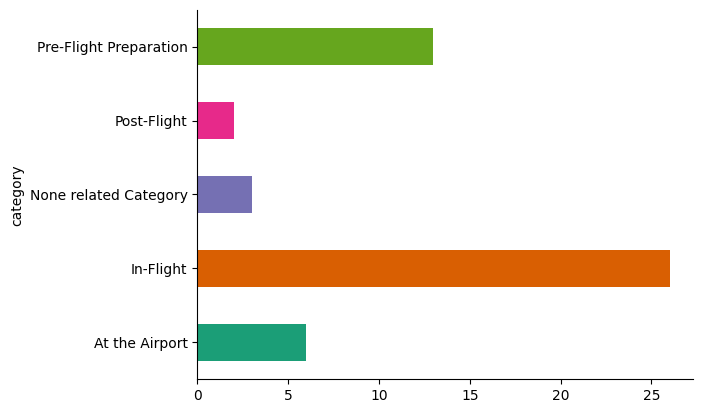

In [81]:
from matplotlib import pyplot as plt
import seaborn as sns
summary_dataset.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

We can observe that the majority of reviews fell into the category "In-Flight" while "Post-Flight" had the least number of reviews.



In [82]:
summary_dataset.loc[summary_dataset['category']=="Post-Flight"][['original_review','reason']].value_counts()

,,count
original_review,reason,
We flew to Fuerteventura for Oct half term. Flight out was ok but the flight back TCX6335 was delayed for 23 hours due to a technical fault. Having sat on the tarmac for 2 hours we were sent to a shabby hotel for the night. Children on the flight back had to pay for earphones despite the horrendous delay. This is not the way to treat your customers. We will not book with Thomas Cook again. Finally got home at 2am on Monday morning when we should have been back on Saturday night.,"The feedback discusses the experience after the flight, specifically the significant delay, being sent to a hotel, and the overall dissatisfaction with the treatment received, which all occurred after the flight was completed.",1
We recently returned from Dublin to Toronto then on to Winnipeg. Other than cutting it close due to limited staffing in Toronto our flight was excellent. Due to the rush in Toronto one of our carry ones was placed to go in the cargo hold. When we arrived in Winnipeg it stayed in Toronto they were most helpful and kind at the Winnipeg airport and we received 3 phone calls the following day in regards to the misplaced bag and it was delivered to our home. We are very thankful and more than appreciative of the service we received what a great end to a wonderful holiday.,"The feedback discusses the experience after arriving in Winnipeg, specifically regarding the misplaced bag and the helpful service received at the airport, including follow-up phone calls and delivery of the bag, which all occurred after leaving the arrival airport.",1


*From examining the "Post-Flight" category, we observe that there was only two marked reviews. They were both inline with the definition we defined for the post-flight category.*

Below we explore the full breakdown of a random categorised review


In [85]:
print("Review:",summary_dataset['original_review'][5])
print("Predicted Category:",summary_dataset['category'][5])
print("Reason:",summary_dataset['reason'][5])

Review: Another nice flight with Garuda from CGK-PKU with GA 178 on April 20. Great foods friendly and nice FA's smooth take off and landed and on time. The airplane was new and very clean.
Predicted Category: In-Flight
Reason: The feedback mentions great food, friendly flight attendants, and a smooth takeoff and landing, which are all experiences related to the service and comfort during the flight itself. It also notes the cleanliness of the airplane, contributing to the in-flight experience.


In [86]:
print("Number of words to describe category reason:",len(summary_dataset['reason'][5].split())) # checking if the agent respected the max number of words to be used.

Number of words to describe category reason: 41


### **Conclusion**

Through this simple illustration, we show how to apply ChatGpt agents to a specified labelling tasked based on categories which we defined.

By using precised prompts, we were able to get correctly labled reviews in the exact format we specified.